# Evidential Loss for Segmentation


How to incorporate for imbalanced class

## Modify from 2D loss to 3D loss 


In [1]:
import torch 
n_batch = 24
n_classes = 8 
avoid_class = 0

In [2]:
pred = torch.rand(n_batch, n_classes)
print (pred.shape)
y = torch.randint(1, 8, (n_batch,))
print (y.shape, y)
one_hot_y = torch.nn.functional.one_hot(y)
print (one_hot_y.shape)

torch.Size([24, 8])
torch.Size([24]) tensor([3, 7, 3, 2, 5, 5, 6, 7, 7, 5, 5, 4, 2, 4, 4, 1, 7, 6, 1, 4, 4, 3, 7, 2])
torch.Size([24, 8])


In [3]:
torch.nn.functional.one_hot(torch.tensor([0, 1]))


tensor([[1, 0],
        [0, 1]])

In [4]:
import torch
import torch.nn.functional as F


def relu_evidence(y):
    return F.relu(y)

def squareplus_evidence(x):
    return (x + np.sqrt(x**2 + 4))/2

def softplus_evidence(y):
    return F.softplus(y)


def kl_divergence(alpha, num_classes, device=None):
    if not device:
        device = get_device()
    ones = torch.ones([1, num_classes], dtype=torch.float32, device=device)
    sum_alpha = torch.sum(alpha, dim=1, keepdim=True)
    first_term = (
        torch.lgamma(sum_alpha)
        - torch.lgamma(alpha).sum(dim=1, keepdim=True)
        + torch.lgamma(ones).sum(dim=1, keepdim=True)
        - torch.lgamma(ones.sum(dim=1, keepdim=True))
    )
    second_term = (
        (alpha - ones)
        .mul(torch.digamma(alpha) - torch.digamma(sum_alpha))
        .sum(dim=1, keepdim=True)
    )
    kl = first_term + second_term
    return kl


def loglikelihood_loss(y, alpha, device=None):
    if not device:
        device = get_device()
    y = y.to(device)
    alpha = alpha.to(device)
    S = torch.sum(alpha, dim=1, keepdim=True)
    loglikelihood_err = torch.sum((y - (alpha / S)) ** 2, dim=1, keepdim=True)
    loglikelihood_var = torch.sum(
        alpha * (S - alpha) / (S * S * (S + 1)), dim=1, keepdim=True
    )
    loglikelihood = loglikelihood_err + loglikelihood_var
    return loglikelihood


def mse_loss(y, alpha, epoch_num, num_classes, annealing_step, device=None):
    if not device:
        device = get_device()
    y = y.to(device)
    alpha = alpha.to(device)
    loglikelihood = loglikelihood_loss(y, alpha, device=device)

    annealing_coef = torch.min(
        torch.tensor(1.0, dtype=torch.float32),
        torch.tensor(epoch_num / annealing_step, dtype=torch.float32),
    )

    kl_alpha = (alpha - 1) * (1 - y) + 1
    kl_div = annealing_coef * kl_divergence(kl_alpha, num_classes, device=device)
    return loglikelihood + kl_div


def edl_loss(func, y, alpha, epoch_num, num_classes, annealing_step, device=None):
    y = y.to(device)
    alpha = alpha.to(device)
    S = torch.sum(alpha, dim=1, keepdim=True)
    
    A = torch.sum(y * (func(S) - func(alpha)), dim=1, keepdim=True)

    annealing_coef = torch.min(
        torch.tensor(1.0, dtype=torch.float32),
        torch.tensor(epoch_num / annealing_step, dtype=torch.float32),
    )

    kl_alpha = (alpha - 1) * (1 - y) + 1
    kl_div = annealing_coef * kl_divergence(kl_alpha, num_classes, device=device)
    return A + kl_div


def edl_mse_loss(output, target, epoch_num, num_classes, annealing_step, device=None):
    if not device:
        device = get_device()
    evidence = relu_evidence(output)
    alpha = evidence + 1
    loss = torch.mean(
        mse_loss(target, alpha, epoch_num, num_classes, annealing_step, device=device)
    )
    return loss


def edl_log_loss(output, target, epoch_num, num_classes, annealing_step, device=None):
    if not device:
        device = get_device()
    evidence = relu_evidence(output)
    alpha = evidence + 1
    loss = torch.mean(
        edl_loss(
            torch.log, target, alpha, epoch_num, num_classes, annealing_step, device
        )
    )
    return loss


def edl_digamma_loss(
    output, target, epoch_num, num_classes, annealing_step, device=None
):
    if not device:
        device = get_device()
    evidence = relu_evidence(output)
    alpha = evidence + 1
    loss = torch.mean(
        edl_loss(
            torch.digamma, target, alpha, epoch_num, num_classes, annealing_step, device
        )
    )
    return loss

In [19]:
# Shape of the mask should be [batch_size, num_classes, height, width]
height = 32
width = 32
y_pred = torch.rand(n_batch, n_classes, height, width)
print (y_pred.shape)
y_true = torch.randint(0, 8, (n_batch, 1, height,width))
print (y_true.shape)
#one_hot_y = torch.nn.functional.one_hot(y, )
#print (one_hot_y.shape)

torch.Size([24, 8, 32, 32])
torch.Size([24, 1, 32, 32])


In [12]:
assert y_true.size(0) == y_pred.size(0)


y_pred = y_pred.log_softmax(dim=1).exp()
    
bs = y_true.size(0)
num_classes = y_pred.size(1)
dims = (0, 2)

In [17]:
y_true = y_true.view(bs, -1)
y_pred = y_pred.view(bs, num_classes, -1)
print (y_true.shape, y_pred.shape)

torch.Size([24, 65536]) torch.Size([24, 8, 24576])


In [14]:
y_true = F.one_hot(y_true, num_classes)  # N,H*W -> N,H*W, C
y_true = y_true.permute(0, 2, 1)  # H, C, H*W
print (y_true.shape, y_pred.shape)

torch.Size([24, 8, 1024]) torch.Size([24, 8, 1024])


In [20]:
mask = y_true != 0.0
y_pred = y_pred * mask.unsqueeze(1)

y_true = F.one_hot((y_true * mask).to(torch.long), num_classes)  # N,H*W -> N,H*W, C
y_true = y_true.permute(0, 2, 1) * mask.unsqueeze(1)  # H, C, H*W

print (y_true.shape, y_pred.shape)

RuntimeError: number of dims don't match in permute

In [15]:
edl_mse_loss(y_pred, y_true, 5, n_classes, 1, 'cpu')

RuntimeError: The size of tensor a (1024) must match the size of tensor b (8) at non-singleton dimension 2

-------------------------------------

# Testing Uncertaity Calculations

In [23]:
n_batch = 24
n_classes = 8
# Shape of the mask should be [batch_size, num_classes, height, width]
height = 32
width = 32
y_pred = torch.rand(n_batch, n_classes, height, width)
print (y_pred.shape)

torch.Size([24, 8, 32, 32])


In [28]:
relu_pred = torch.relu(y_pred)
print (relu_pred.shape)

torch.Size([24, 8, 32, 32])


In [25]:
sum_evidence = torch.sum(y_pred, dim=1, keepdim=True)
print (sum_evidence.shape)

torch.Size([24, 1, 32, 32])


In [37]:
prob = relu_pred / torch.sum(relu_pred, dim=1, keepdim=True)
prob[0][0]

tensor([[0.1627, 0.1109, 0.1614,  ..., 0.3280, 0.0385, 0.0915],
        [0.1867, 0.0449, 0.2048,  ..., 0.0665, 0.0601, 0.0007],
        [0.1835, 0.0186, 0.1835,  ..., 0.0553, 0.2569, 0.0043],
        ...,
        [0.0194, 0.1407, 0.0222,  ..., 0.1619, 0.3135, 0.1512],
        [0.0726, 0.1861, 0.1176,  ..., 0.2810, 0.0496, 0.0498],
        [0.1569, 0.0679, 0.1504,  ..., 0.0940, 0.0991, 0.0031]])

---------------------------------------------

In [77]:
x = torch.randint(0, 8, (2, 1, 5, 5))
x

tensor([[[[6, 5, 0, 2, 5],
          [4, 4, 4, 3, 1],
          [1, 1, 3, 5, 5],
          [4, 2, 1, 0, 3],
          [5, 2, 6, 2, 2]]],


        [[[4, 6, 2, 2, 4],
          [1, 4, 3, 6, 5],
          [5, 4, 7, 4, 3],
          [2, 2, 3, 0, 0],
          [4, 0, 4, 4, 5]]]])

In [78]:
x = x.view(2, -1)

x = F.one_hot(x, 8)  # N,H*W -> N,H*W, C
x = x.permute(0, 2, 1)  # H, C, H*W

x.shape

torch.Size([2, 8, 25])

In [79]:
x[0][0]

tensor([0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
        0])

In [80]:
z = x.permute(0, 2, 1)
z.shape

torch.Size([2, 25, 8])

In [82]:
torch.argmax(z.view(-1, 8), dim=1)

tensor([6, 5, 0, 2, 5, 4, 4, 4, 3, 1, 1, 1, 3, 5, 5, 4, 2, 1, 0, 3, 5, 2, 6, 2,
        2, 4, 6, 2, 2, 4, 1, 4, 3, 6, 5, 5, 4, 7, 4, 3, 2, 2, 3, 0, 0, 4, 0, 4,
        4, 5])

------------------------

In [33]:
# Shape of the mask should be [batch_size, num_classes, height, width]
height = 32
width = 32
y_pred = torch.rand(n_batch, n_classes, height, width)
print (y_pred.shape)
y_true = torch.randint(0, 8, (n_batch, 1, height,width))
print (y_true.shape)

torch.Size([24, 8, 32, 32])
torch.Size([24, 1, 32, 32])


In [34]:
assert y_true.size(0) == y_pred.size(0)


y_pred = y_pred.log_softmax(dim=1).exp()
    
bs = y_true.size(0)
num_classes = y_pred.size(1)
dims = (0, 2)

In [35]:
y_true = y_true.view(bs, -1)
y_pred = y_pred.view(bs, num_classes, -1)
print (y_true.shape, y_pred.shape)

torch.Size([24, 1024]) torch.Size([24, 8, 1024])


In [36]:
y_true = F.one_hot(y_true, num_classes)  # N,H*W -> N,H*W, C
print (y_true.shape, y_pred.shape)

torch.Size([24, 1024, 8]) torch.Size([24, 8, 1024])


In [37]:
y_true = y_true.view(-1, 8)
y_true.shape

torch.Size([24576, 8])

In [38]:
y_pred = y_pred.permute(0,2,1)
y_pred.shape

torch.Size([24, 1024, 8])

In [41]:
y_pred = y_pred.reshape_as(y_true)

In [42]:
y_pred.sum(dim=1)

tensor([1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000])

In [43]:
edl_mse_loss(y_pred, y_true, 5, n_classes, 1, 'cpu')

tensor(0.9999)

In [16]:
# Shape of the mask should be [batch_size, num_classes, height, width]
height = 3
width = 3
num_classes = 5
n_batch = 2
ignore_class = 0.
d = torch.arange(height*width*num_classes*n_batch)

#y_pred = torch.rand(n_batch, num_classes, height, width)
y_pred = torch.rand(n_batch, num_classes, height, width)
print (y_pred.shape)
y_true = torch.randint(0, num_classes, (n_batch, 1, height,width))
print (y_true.shape)


assert y_true.size(0) == y_pred.size(0)
y_pred = y_pred.log_softmax(dim=1).exp()
bs = y_true.size(0)
num_classes = y_pred.size(1)

y_true = torch.ravel(y_true)
idx_ignore = y_true != ignore_class

y_true = F.one_hot(y_true, num_classes)  # N,H*W -> N,H*W, C

y_pred = y_pred.view(bs, num_classes, -1)
y_pred = y_pred.reshape_as(y_true)
print (y_true.shape, y_pred.shape)
print (y_true[idx_ignore].shape, y_pred[idx_ignore].shape)

torch.Size([2, 5, 3, 3])
tensor([[0.4538, 0.2266, 0.8949],
        [0.7989, 0.0054, 0.2252],
        [0.9436, 0.8686, 0.0055]])
torch.Size([2, 1, 3, 3])
torch.Size([18, 5]) torch.Size([18, 5])
torch.Size([17, 5]) torch.Size([17, 5])


In [67]:
y_pred = y_pred.reshape(bs, num_classes, height,width)

In [68]:
y_pred.shape

torch.Size([12, 5, 32, 32])

In [69]:
y_pred[0][0]

tensor([[0.2963, 0.2878, 0.1268,  ..., 0.2568, 0.2061, 0.2738],
        [0.2905, 0.2150, 0.1313,  ..., 0.2057, 0.1935, 0.1731],
        [0.1845, 0.1325, 0.1992,  ..., 0.1453, 0.1413, 0.2521],
        ...,
        [0.1688, 0.2776, 0.2086,  ..., 0.1523, 0.1474, 0.2327],
        [0.3023, 0.2460, 0.1414,  ..., 0.1712, 0.1550, 0.1468],
        [0.2434, 0.1926, 0.3380,  ..., 0.1742, 0.1974, 0.2611]])

In [1]:
import torch
import torch.nn.functional as F


In [23]:
# Shape of the mask should be [batch_size, num_classes, height, width]
height = 3
width = 3
num_classes = 5
n_batch = 2
ignore_class = 0.


d = torch.arange(height*width*num_classes*n_batch)
d

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
        36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53,
        54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71,
        72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89])

In [24]:
y_pred = d.reshape(n_batch, num_classes, height, width)
y_pred.shape

torch.Size([2, 5, 3, 3])

In [25]:
y_true = torch.randint(0, num_classes, (n_batch, 1, height,width))
print (y_true.shape)


torch.Size([2, 1, 3, 3])


In [26]:

y_true = torch.ravel(y_true)

y_true = F.one_hot(y_true, num_classes)  # N,H*W -> N,H*W, C
print (y_true.shape)
print (y_true)

y_pred = y_pred.view(n_batch, num_classes, -1)
y_pred = y_pred.reshape_as(y_true)
print (y_true.shape, y_pred.shape)

torch.Size([18, 5])
tensor([[0, 0, 1, 0, 0],
        [0, 0, 1, 0, 0],
        [1, 0, 0, 0, 0],
        [0, 0, 0, 0, 1],
        [0, 0, 0, 1, 0],
        [0, 0, 0, 0, 1],
        [0, 1, 0, 0, 0],
        [0, 1, 0, 0, 0],
        [1, 0, 0, 0, 0],
        [1, 0, 0, 0, 0],
        [1, 0, 0, 0, 0],
        [1, 0, 0, 0, 0],
        [0, 0, 0, 0, 1],
        [0, 0, 1, 0, 0],
        [0, 0, 1, 0, 0],
        [0, 1, 0, 0, 0],
        [0, 1, 0, 0, 0],
        [0, 0, 0, 0, 1]])
torch.Size([18, 5]) torch.Size([18, 5])


In [20]:
y_pred

tensor([[ 0,  1,  2,  3,  4],
        [ 5,  6,  7,  8,  9],
        [10, 11, 12, 13, 14],
        [15, 16, 17, 18, 19],
        [20, 21, 22, 23, 24],
        [25, 26, 27, 28, 29],
        [30, 31, 32, 33, 34],
        [35, 36, 37, 38, 39],
        [40, 41, 42, 43, 44],
        [45, 46, 47, 48, 49],
        [50, 51, 52, 53, 54],
        [55, 56, 57, 58, 59],
        [60, 61, 62, 63, 64],
        [65, 66, 67, 68, 69],
        [70, 71, 72, 73, 74],
        [75, 76, 77, 78, 79],
        [80, 81, 82, 83, 84],
        [85, 86, 87, 88, 89]])

In [21]:
y_pred.reshape(n_batch, num_classes, height, width)

tensor([[[[ 0,  1,  2],
          [ 3,  4,  5],
          [ 6,  7,  8]],

         [[ 9, 10, 11],
          [12, 13, 14],
          [15, 16, 17]],

         [[18, 19, 20],
          [21, 22, 23],
          [24, 25, 26]],

         [[27, 28, 29],
          [30, 31, 32],
          [33, 34, 35]],

         [[36, 37, 38],
          [39, 40, 41],
          [42, 43, 44]]],


        [[[45, 46, 47],
          [48, 49, 50],
          [51, 52, 53]],

         [[54, 55, 56],
          [57, 58, 59],
          [60, 61, 62]],

         [[63, 64, 65],
          [66, 67, 68],
          [69, 70, 71]],

         [[72, 73, 74],
          [75, 76, 77],
          [78, 79, 80]],

         [[81, 82, 83],
          [84, 85, 86],
          [87, 88, 89]]]])

In [22]:
y_true = y_true.reshape(n_batch, num_classes, height, width)
y_true.argma

tensor([[[[0, 0, 1],
          [0, 0, 0],
          [0, 1, 0]],

         [[0, 0, 1],
          [0, 0, 0],
          [0, 0, 0]],

         [[0, 1, 0],
          [0, 0, 0],
          [1, 0, 1]],

         [[0, 0, 0],
          [0, 0, 0],
          [0, 1, 0]],

         [[1, 0, 0],
          [0, 0, 0],
          [1, 0, 0]]],


        [[[1, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],

         [[1, 0, 0],
          [1, 0, 0],
          [0, 0, 1]],

         [[0, 0, 1],
          [0, 0, 0],
          [0, 0, 0]],

         [[1, 0, 0],
          [0, 0, 0],
          [1, 0, 0]],

         [[1, 0, 0],
          [0, 0, 0],
          [0, 0, 1]]]])

In [30]:
y_true = torch.randint(0, num_classes, (n_batch, 1, height,width))
y_true = torch.ravel(y_true)
y_true

tensor([3, 2, 2, 4, 1, 0, 3, 4, 3, 4, 2, 4, 2, 0, 4, 0, 1, 0])

In [31]:
#Remove pixels exculding the background loss function
idx_background = y_true== ignore_class
idx_only_objects = y_true != ignore_class
idx_only_objects

tensor([ True,  True,  True,  True,  True, False,  True,  True,  True,  True,
         True,  True,  True, False,  True, False,  True, False])

In [32]:
y_true[idx_background]

tensor([0, 0, 0, 0])

In [33]:
y_true[idx_only_objects]

tensor([3, 2, 2, 4, 1, 3, 4, 3, 4, 2, 4, 2, 4, 1])

In [36]:
a = torch.ones(3, 3)
torch.bernoulli(0.3*a)

tensor([[0., 0., 0.],
        [0., 1., 0.],
        [0., 0., 0.]])

In [1]:
import h5py
import numpy as np
import json

In [2]:
!ls ../learning_blenerproc/images_pose_robocup/


12.hdf5  13.hdf5  14.hdf5


In [22]:
!pip install pytransform3d

     |████████████████████████████████| 77 kB 1.5 MB/s eta 0:00:01
     |████████████████████████████████| 6.9 MB 4.5 MB/s eta 0:00:01
  Using cached beautifulsoup4-4.10.0-py3-none-any.whl (97 kB)
  Using cached soupsieve-2.3.1-py3-none-any.whl (37 kB)
  Created wheel for pytransform3d: filename=pytransform3d-1.12.1-py3-none-any.whl size=86379 sha256=d3c56bd7d54b45f68477c5b2c7ac298a7ae665000464ad1c31a93aa9417b301e
  Stored in directory: /home/deebuls/.cache/pip/wheels/7f/b1/6e/2b61a919aff53b1f63db03b9b39bc8d9ebba508a1f4c24c897
Successfully built pytransform3d


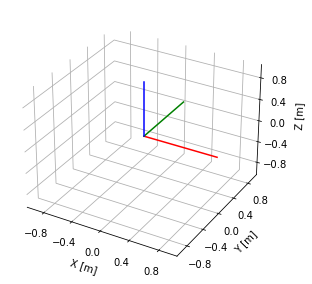

In [3]:


import matplotlib.pyplot as plt
from pytransform3d.transformations import plot_transform
from pytransform3d.plot_utils import make_3d_axis

ax = make_3d_axis(ax_s=1, unit="m", n_ticks=6)
plot_transform(ax=ax)
plt.tight_layout()
plt.show()


In [4]:


import numpy as np
import matplotlib.pyplot as plt
from pytransform3d.plot_utils import make_3d_axis
from pytransform3d.transformations import random_transform
from pytransform3d.transform_manager import TransformManager
from pytransform3d import rotations as pr
from pytransform3d import transformations as pt
from pytransform3d.transform_manager import TransformManager



ee2robot = pt.transform_from_pq(
    np.hstack((np.array([0.4, -0.3, 0.5]),
               pr.random_quaternion(random_state))))
cam2robot = pt.transform_from_pq(
    np.hstack((np.array([0.0, 0.0, 0.8]), pr.q_id)))
object2cam = pt.transform_from(
    pr.active_matrix_from_intrinsic_euler_xyz(np.array([0.0, 0.0, -0.5])),
    np.array([0.5, 0.1, 0.1]))

tm = TransformManager()
tm.add_transform("end-effector", "robot", ee2robot)
tm.add_transform("camera", "robot", cam2robot)
tm.add_transform("object", "camera", object2cam)

ee2object = tm.get_transform("end-effector", "object")

ax = tm.plot_frames_in("robot", s=0.1)
ax.set_xlim((-0.25, 0.75))
ax.set_ylim((-0.5, 0.5))
ax.set_zlim((0.0, 1.0))
plt.show()

NameError: name 'random_state' is not defined

######  12.hdf5
image shape  (512, 512, 3)
mask shape  (512, 512)
Keys: <KeysViewHDF5 ['blender_proc_version', 'camera_pose', 'class_segmaps', 'colors']>
[711.1112738715278, 0.0, 255.5, 0.0, 711.1112738715278, 255.5, 0.0, 0.0, 1.0]
current T  [[-0.01508968]
 [-0.04995073]
 [ 0.94997483]]
######  13.hdf5
image shape  (512, 512, 3)
mask shape  (512, 512)
Keys: <KeysViewHDF5 ['blender_proc_version', 'camera_pose', 'class_segmaps', 'colors']>
[711.1112738715278, 0.0, 255.5, 0.0, 711.1112738715278, 255.5, 0.0, 0.0, 1.0]
current T  [[-0.01540309]
 [-0.04824003]
 [ 0.71599245]]
call
##### -0.2339823842048644
 T with previous frame:  [-3.13405879e-04  1.71070173e-03 -5.00000000e-01]
[[ 7.11111274e+02 -3.54500298e-15 -1.27972866e+02]
 [-9.08425751e-14  7.11111274e+02 -1.26533501e+02]
 [ 1.56125113e-17 -2.77555756e-17  7.10611274e+02]] (3, 3)
[[ 1.00070362e+00 -4.98866696e-18 -1.80088427e-01]
 [-1.27837228e-16  1.00070362e+00 -1.78062895e-01]
 [ 2.19705370e-20 -3.90587324e-20  1.00000000e+00]]
#

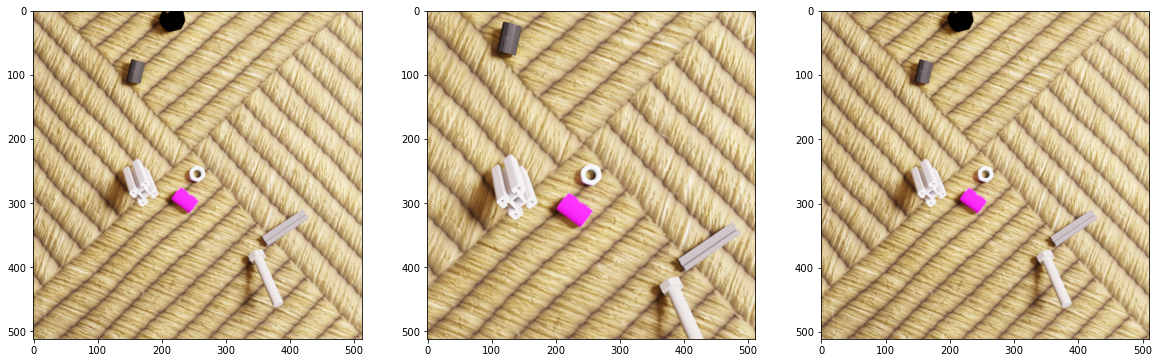

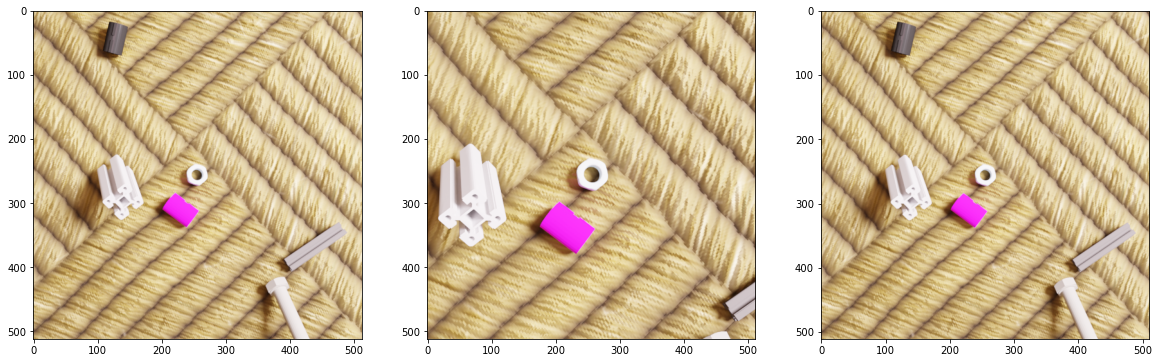

In [28]:
import os
import cv2
files_directory = '../learning_blenerproc/images_pose_robocup/'
filenames = [f for f in sorted(os.listdir(files_directory)) if os.path.isfile(os.path.join(files_directory, f))]
transformation_matrix = []
tm = TransformManager()
old_pose_flag = None
old_pose = None
old_image = None
for filename in filenames:
    file_path = os.path.join(files_directory, filename)

    with h5py.File(file_path, 'r') as data:
        print ("###### ", filename)
        image = np.array(data['colors'])
        print ("image shape ", image.shape)
        mask = np.array(data['class_segmaps'])
        print ("mask shape ", mask.shape)

        # List all groups
        print("Keys: %s" % data.keys())
        transformation_matrix = json.loads(np.array(data['camera_pose']).item().decode()) 
        print (transformation_matrix['cam_K'])
        R = np.array(transformation_matrix['cam_R_w2c']).reshape(3,3)
        T = np.array(transformation_matrix['cam_t_w2c']).reshape(3,1)
        print ("current T ", T)
        H=np.hstack((R,T))
        H = np.vstack((H,[0., 0., 0., 1.]))
        tm.add_transform("world", filename, H)
       
        
        if old_pose_flag:
            print ("call")
            dst = transform_segmask(transformation_matrix['cam_K'], old_pose, H, 
                                    old_image)
            
           
            #plotting
            plt.figure(figsize=(20, 10))
            ax = plt.subplot(1, 3, 1)
            plt.imshow(old_image)
            ax = plt.subplot(1, 3, 2)
            plt.imshow(image)
            ax = plt.subplot(1, 3, 3)
            plt.imshow(dst)
            old_pose = H
            old_image = image
        else:
            old_pose_flag = True
            old_pose = H
            old_image = image
        
        

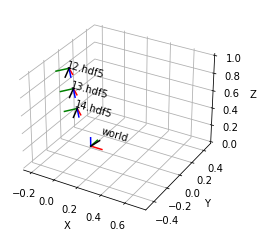

In [29]:

ax = tm.plot_frames_in("world", s=0.1)
ax.set_xlim((-0.25, 0.75))
ax.set_ylim((-0.5, 0.5))
ax.set_zlim((0.0, 1.0))
plt.show()

In [5]:
!pip install opencv-python

In [6]:
import cv2

In [40]:
def give_rotation_translation(old_pose, new_pose):
    tm = TransformManager()
    tm.add_transform("world", "old_pose", old_pose)
    tm.add_transform("world", "new_pose", new_pose)
    new2old = tm.get_transform("old_pose", "new_pose")
    return new2old

def transform_segmask(cam_matrix, old_pose, new_pose, old_seg):
    height = cam_matrix[5]
    width = cam_matrix[2]
    f = cam_matrix[0]
    K = np.array(cam_matrix).reshape(3,3)
    K = np.hstack((K, [[0.],[0.],[0.]]))
    Kinv= np.matrix([[1, 0, -width],
                [0, 1, -height],
                [0, 0, f  ],
                [0, 0, 1   ]])
    T = give_rotation_translation(old_pose, new_pose)
    print ('#####',T[2,3])
    T[:3, 3] = T[:3, 3] * 1000
    print (" T with previous frame: ", T[:3,3])
    #T[:3, 3] = 0.0
    
    #T = np.matrix([[1, 0, 0, 0],
    #               [0, 1, 0, 0],
    #               [0, 0, 1, 0],
    #               [0, 0, 0, 1]])
    #print (K, Kinv)
    # Final and overall transformation matrix
    print ('######### K')
    print (K)
    print ('######### T')
    print (T)
    print ('######### Kinv')
    print (Kinv)
    
    H = K * (T * Kinv)
    print (H, H.shape)
    #Normalizing Homography matrix (Please find reference for this )
    H = H/H[2,2]
    print (H)
    
    # Apply matrix transformation
    dst = cv2.warpPerspective(old_seg, H, (int(width*2), int(height*2)), flags=cv2.INTER_NEAREST,
                              borderMode=cv2.BORDER_CONSTANT, borderValue=0)
    
    return dst

######  12.hdf5
image shape  (512, 512, 3)
mask shape  (512, 512)
Keys: <KeysViewHDF5 ['blender_proc_version', 'camera_pose', 'class_segmaps', 'colors']>
[711.1112738715278, 0.0, 255.5, 0.0, 711.1112738715278, 255.5, 0.0, 0.0, 1.0]
current T  [[-0.01508968]
 [-0.04995073]
 [ 0.94997483]]
######  13.hdf5
image shape  (512, 512, 3)
mask shape  (512, 512)
Keys: <KeysViewHDF5 ['blender_proc_version', 'camera_pose', 'class_segmaps', 'colors']>
[711.1112738715278, 0.0, 255.5, 0.0, 711.1112738715278, 255.5, 0.0, 0.0, 1.0]
current T  [[-0.01540309]
 [-0.04824003]
 [ 0.71599245]]
call
##### -0.2339823842048644
 T with previous frame:  [  -0.31340588    1.71070173 -233.9823842 ]
######### K
[[711.11127387   0.         255.5          0.        ]
 [  0.         711.11127387 255.5          0.        ]
 [  0.           0.           1.           0.        ]]
######### T
[[ 1.00000000e+00  4.98732999e-18  0.00000000e+00 -3.13405879e-01]
 [-1.33356867e-16  1.00000000e+00  0.00000000e+00  1.71070173e+00

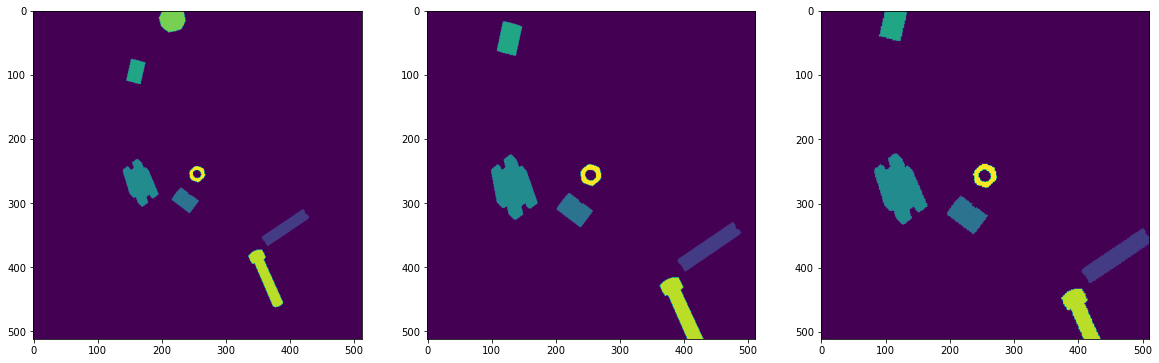

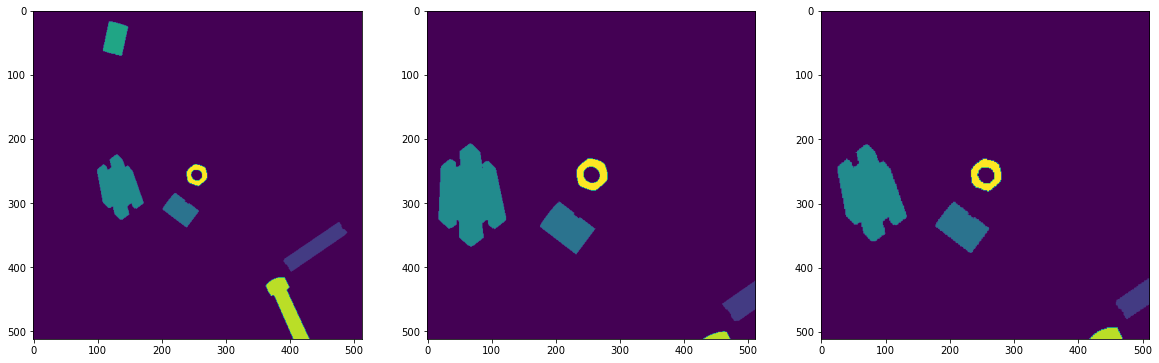

In [42]:
import os
import cv2
files_directory = '../learning_blenerproc/images_pose_robocup/'
filenames = [f for f in sorted(os.listdir(files_directory)) if os.path.isfile(os.path.join(files_directory, f))]
transformation_matrix = []
tm = TransformManager()
old_pose_flag = None
old_pose = None
old_image = None
for filename in filenames:
    file_path = os.path.join(files_directory, filename)

    with h5py.File(file_path, 'r') as data:
        print ("###### ", filename)
        image = np.array(data['colors'])
        print ("image shape ", image.shape)
        mask = np.array(data['class_segmaps'])
        print ("mask shape ", mask.shape)

        # List all groups
        print("Keys: %s" % data.keys())
        transformation_matrix = json.loads(np.array(data['camera_pose']).item().decode()) 
        print (transformation_matrix['cam_K'])
        R = np.array(transformation_matrix['cam_R_w2c']).reshape(3,3)
        T = np.array(transformation_matrix['cam_t_w2c']).reshape(3,1)
        print ("current T ", T)
        H=np.hstack((R,T))
        H = np.vstack((H,[0., 0., 0., 1.]))
        
        if old_pose_flag:
            print ("call")
            dst = transform_segmask(transformation_matrix['cam_K'], old_pose, H, 
                                    old_image)
            
           
            #plotting
            plt.figure(figsize=(20, 10))
            ax = plt.subplot(1, 3, 1)
            plt.imshow(old_image)
            ax = plt.subplot(1, 3, 2)
            plt.imshow(mask)
            ax = plt.subplot(1, 3, 3)
            plt.imshow(dst)
            old_pose = H
            old_image = mask
        else:
            old_pose_flag = True
            old_pose = H
            old_image = mask
        
        

In [26]:

ax = tm.plot_frames_in("world", s=0.2)
#ax.set_xlim((-0.25, 0.75))
#ax.set_ylim((-0.5, 0.5))
#ax.set_zlim((0.0, 1.0))
plt.show()

KeyError: "Unknown frame 'world'"

In [97]:

next2first = tm.get_transform("12.hdf5", "13.hdf5")
next2first[:3,3]

array([-0.00031341,  0.0017107 , -0.23398238])

In [77]:
R = np.array(transformation_matrix['cam_R_w2c']).reshape(3,3)
T = np.array(transformation_matrix['cam_t_w2c']).reshape(3,1)
H=np.hstack((R,T))
H = np.vstack((H,[0., 0., 0., 1.]))
H

array([[ 0.73064965, -0.68266475,  0.01095367, -0.01540309],
       [-0.67731899, -0.72676164, -0.1142657 , -0.04824003],
       [ 0.08596587,  0.07606906, -0.9933899 ,  0.71599245],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

In [41]:
import json

In [47]:
data = json.loads(transformation_matrix)

TypeError: the JSON object must be str, bytes or bytearray, not ndarray

In [53]:
class NumpyEncoder(json.JSONEncoder):
    """ A json encoder that is also capable of serializing numpy arrays """

    def default(self, obj):
        # If its a numpy array
        if isinstance(obj, np.ndarray):
            # Convert it to a list
            return obj.tolist()
        return json.JSONEncoder.default(self, obj)

In [58]:
data = np.string_(json.dumps(d, cls=NumpyEncoder))
data

b'{"cam_K": [711.1112738715278, 0.0, 255.5, 0.0, 711.1112738715278, 255.5, 0.0, 0.0, 1.0], "cam_R_w2c": [0.7306496500968933, -0.6826647520065308, 0.010953672230243683, -0.6773189902305603, -0.7267616391181946, -0.11426570266485214, 0.08596587181091309, 0.07606906443834305, -0.993389904499054], "cam_t_w2c": [-0.015403085388243198, -0.04824003204703331, 0.7159924507141113]}'

In [59]:
data = np.array(data)
data

array(b'{"cam_K": [711.1112738715278, 0.0, 255.5, 0.0, 711.1112738715278, 255.5, 0.0, 0.0, 1.0], "cam_R_w2c": [0.7306496500968933, -0.6826647520065308, 0.010953672230243683, -0.6773189902305603, -0.7267616391181946, -0.11426570266485214, 0.08596587181091309, 0.07606906443834305, -0.993389904499054], "cam_t_w2c": [-0.015403085388243198, -0.04824003204703331, 0.7159924507141113]}',
      dtype='|S372')

In [66]:
json.loads(data.item().decode())

{'cam_K': [711.1112738715278,
  0.0,
  255.5,
  0.0,
  711.1112738715278,
  255.5,
  0.0,
  0.0,
  1.0],
 'cam_R_w2c': [0.7306496500968933,
  -0.6826647520065308,
  0.010953672230243683,
  -0.6773189902305603,
  -0.7267616391181946,
  -0.11426570266485214,
  0.08596587181091309,
  0.07606906443834305,
  -0.993389904499054],
 'cam_t_w2c': [-0.015403085388243198,
  -0.04824003204703331,
  0.7159924507141113]}

In [55]:
d = {"cam_K": [711.1112738715278, 0.0, 255.5, 0.0, 711.1112738715278, 255.5, 0.0, 0.0, 1.0], "cam_R_w2c": [0.7306496500968933, -0.6826647520065308, 0.010953672230243683, -0.6773189902305603, -0.7267616391181946, -0.11426570266485214, 0.08596587181091309, 0.07606906443834305, -0.993389904499054], "cam_t_w2c": [-0.015403085388243198, -0.04824003204703331, 0.7159924507141113]}

In [56]:
d

{'cam_K': [711.1112738715278,
  0.0,
  255.5,
  0.0,
  711.1112738715278,
  255.5,
  0.0,
  0.0,
  1.0],
 'cam_R_w2c': [0.7306496500968933,
  -0.6826647520065308,
  0.010953672230243683,
  -0.6773189902305603,
  -0.7267616391181946,
  -0.11426570266485214,
  0.08596587181091309,
  0.07606906443834305,
  -0.993389904499054],
 'cam_t_w2c': [-0.015403085388243198,
  -0.04824003204703331,
  0.7159924507141113]}

![title](./03PhDDiscussionLux_March2022.jpg)